## MNIST Classification

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

**Fetch the MNIST Dataset**

`Scikit-learn` provides many helper functions to download popular datasets. By default `Scikit-learn` caches downloaded datasets in a directory called `$HOME/scikit_learn_data`

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

There are 70.000 images, and each image has 784 features (28x28 pixels)

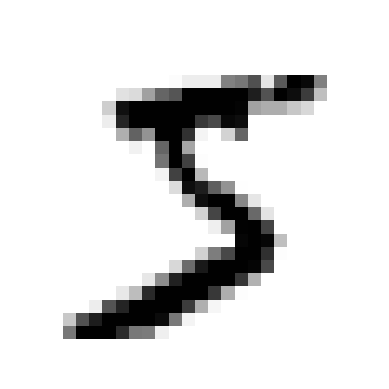

In [4]:
some_digit = x[0]
digit_image = some_digit.reshape(28, 28)

plt.imshow(digit_image, cmap='binary')
plt.axis('off')
plt.show()

The label is

In [5]:
y[0]

'5'

Cast stings into numerical values

In [6]:
y = y.astype(np.uint8)

Create a test set: the MNIST dataset is actually already split into a training set (the first 60.000 images) and a test set (the last 10.000 images). The training set is also already shuffled.

In [7]:
SPLIT = 60000
x_train, x_test, y_train, y_test = x[:SPLIT], x[SPLIT:], y[:SPLIT], y[SPLIT:]

###  1. Train a Binary Classifier

Let's simplify the problem now and try to build a "5-detector"

In [8]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

A good place to start is with a *Stochastic Gradient Descent* classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

Evaluate our model

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Looks nice, or is it? Let's have a look at a *Constant* model for comparison

In [11]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    
    def fit(self, _: np.ndarray, y: np.ndarray) -> 'Never5Classifier':
        return self
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.zeros((len(x), 1), dtype=bool)

    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preffered performance measure for classifiers, especially when you are dealing with a *skewed dataset*.

**Confusion Matrix**

Get the labels for each image using cross validation

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

Get the confusion matrix

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in the matrix represents an *actual* class, while each column represents a *predicted* class. The first row considers non-5 images (the *negative* class):

|  | Predicted not-5 | Predicted 5 |
| --- | --- | --- |
| **Actual not-5** | TN  | FP  |
| **Actual 5** | FN  | TP  |

A perfect classifier would have onlu true positives and true negatives, so its confusion matrix would looks like

In [14]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

When the model claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Precision/Recall Trade-off**

Increasing precision reduces recall, and vice versa. The key concept is a moving decision threshold. Increasing the threshold increases precision and reduces recall. Conversely, lowering the threshold increases recall and reduses precision. We can observe it by controling the threshold manualy.

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [18]:
for threshold in (0, 8000):
    y_some_digit_pred = y_scores > threshold
    print(threshold, y_some_digit_pred)

0 [ True]
8000 [False]


How do you decide which treshold to use? First, get the scores of all samples in the training set

In [19]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

Compute precision and recall for all possible thresholds

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

And plot the results

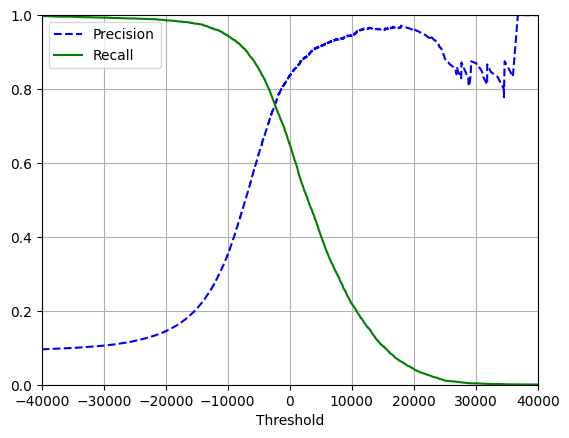

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.xlim(-40000, 40000)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall as the *Precision-Recall curve*

**Precision-Recall Curve**

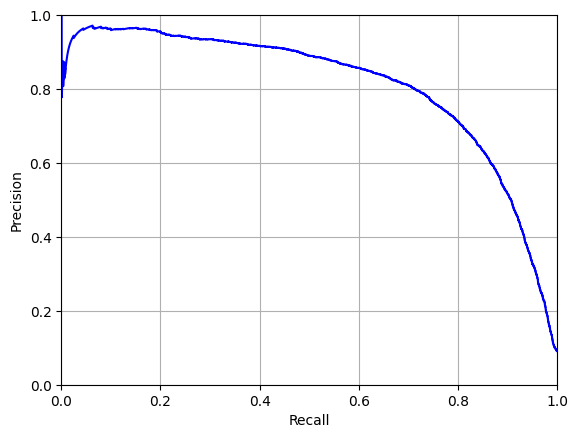

In [22]:
plt.plot(recalls[:-1], precisions[:-1], 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

Suppose you decide to aim for 90% precision. You can search for the lowest threshold that gives you at least 90% precision:

In [23]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [24]:
y_train_pred_90 = y_scores >= threshold_90_precision
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

A high-precision classifier is not very usefull if its recall is too low.

**The ROC Curve**

The *reciver operating characteristic* (ROC) curve is another common tool used with binary classifiers. It is a plot of the TPR (recall) against the FPR.

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

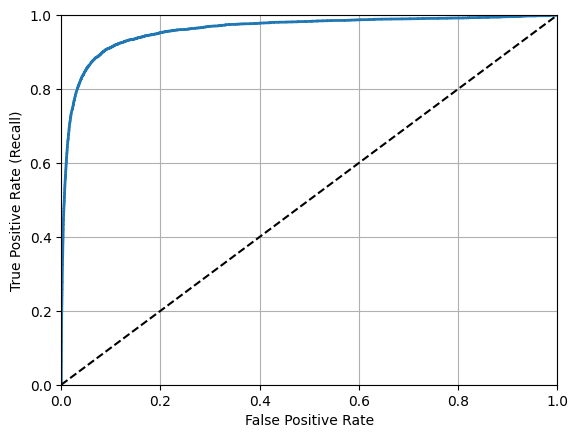

In [26]:
from typing import Optional

def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, label: Optional[str] = None) -> None:
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

We can measure the *area under the curve* (AUC) to compare classifiers.

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Prefer the PR curve whenever the positive class is rare or whenever you care more about the false positives than the false negatives. Overwise, use the ROC curve.

Let's now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`. First, you need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` class does not have a `decision_function()` method. Instead, it has a `predict_proba()` method that returns an array containing a row per instance and a column per class, each containing the *probability* that the given instance belongs to the given class.

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

In [29]:
y_probas_forest[0]

array([0.11, 0.89])

In [30]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Plot the ROC

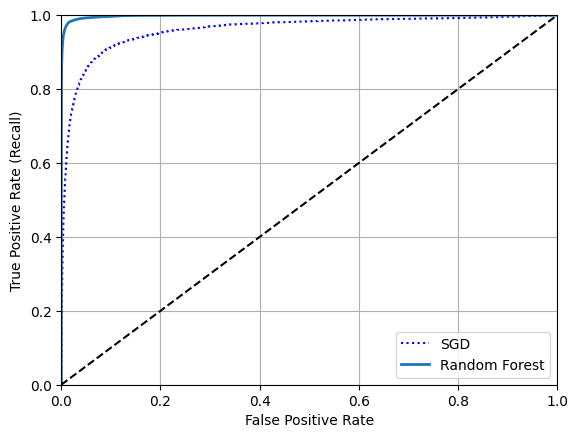

In [31]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The Random Forest classifier is superior to the SGD classifier.

In [33]:
y_train_pred = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict')

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.9905083315756169, 0.8662608374838591)

###  2. Train a Multiclass Classifier

There are various strategies that you can use to perform multiclass classification with multiple binary classifiers:
- *One-vs-Rest* (or *One-vs-All*): each class gets its own binary classifier
- *One-vs-One*: each class pair gets its own detector (if there is N classes, then you train Nx(N-1)/2 binary       classifiers

`Scikit-learn` detects when you try to use a binary classifier for such task, and it automatically runs OvR or OvO, depending on the algorithm you use.

In [34]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, `Scikit-learn` actually uses OvO strategy training 45 binary classificators, got their decision scores for the image, and select the class that won the most duels.

In [35]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [36]:
np.argmax(some_digit_score)

5

In [37]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

You can force `Scikit-learn` to use a certain strategy

In [38]:
from sklearn.multiclass import OneVsRestClassifier

ovr_svm_clf = OneVsRestClassifier(SVC())
ovr_svm_clf.fit(x_train, y_train)
ovr_svm_clf.predict([some_digit])

array([5], dtype=uint8)

Let'r try out `SGDClassifier` that supports multiclass classification directly (so no OvO/OvR strategies)

In [39]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [40]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [41]:
np.argmax(some_digit_score)

3

As usual you can use cross-validation

In [42]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Simply scaling the inputs increases accuracy

In [43]:
from sklearn.preprocessing import StandardScaler

x_train_scaled = StandardScaler().fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### 3. Error Analysis

First, look at the confusion matrix.

In [44]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)

In [45]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

That's a lot of numbers. It's often more convinient to look at an image representation

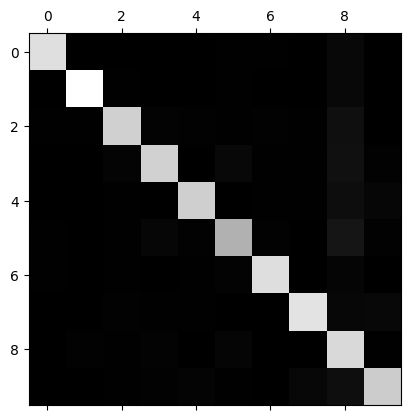

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

We need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only errors

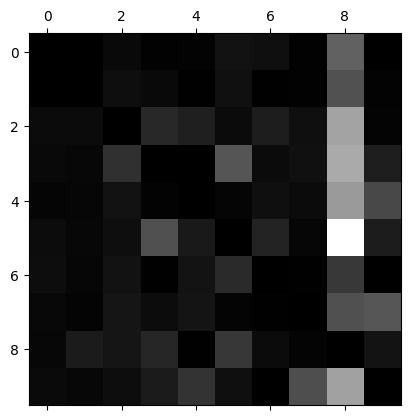

In [48]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Now you can clearly see the kinds of errors the classifier makes. Many images were misclassified as 8s. 3s and 5s often get confused in both direction. A simple `SGDClassifier` we use is just a linear model.

### 4. Multilabel Classification

In some cases you may want your classifier to output multiple classes for each instance.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

The digit 5 is less than 7 and odd.

To evaluate the classifier measure F1 score for each individual label, then compute an average

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train_scaled, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9613989329409902

This assumes that all labels are equally important, which may not be the case. You can give a weight to each label.

### 5. Multioutput Classification

The last type of classification task is called *multioutput-multiclass classification*. To illustrate this let's build a system that removes noise from images. It should assign each of 784 pixel new denoised value.

We add random noise to pixel intensities. The target images will be the original images.

In [52]:
x_train_mod = x_train + np.random.randint(0, 100, (len(x_train), 784))
y_train_mod = x_train

x_test_mod = x_test + np.random.randint(0, 100, (len(x_test), 784))
y_test_mod = x_test

Let's take a peek at an image from the test set

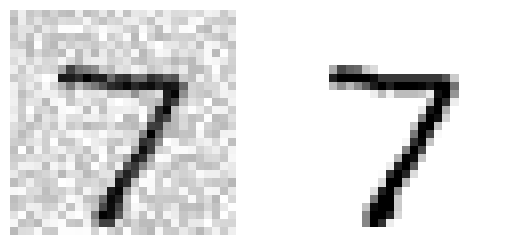

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(x_test_mod[0].reshape(28, 28), cmap='binary')
ax2.imshow(y_test_mod[0].reshape(28, 28), cmap='binary')
ax1.axis('off'); ax2.axis('off')
plt.show()

Train the classifier

In [54]:
knn_clf.fit(x_train_mod, y_train_mod)

KNeighborsClassifier()

And make it clean this image

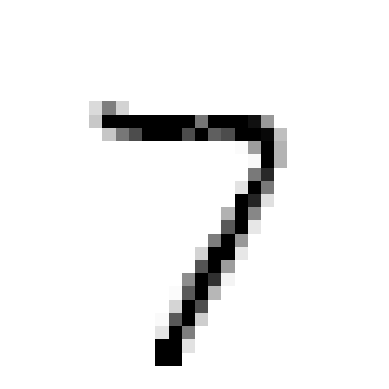

In [55]:
clean_digit = knn_clf.predict([x_test_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()